# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your interests.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [3]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [19]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                      num_iters=10000, verbose=True)
        y_train_pred = svm.predict(X_train_feats)
        y_val_pred = svm.predict(X_val_feats)
        ans = (np.mean(y_train == y_train_pred), np.mean(y_val == y_val_pred))
        results[(lr, reg)] = ans
        if ans[1] > best_val:
            best_val = ans[1]
            best_svm = svm
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 10000: loss 84.741972
iteration 100 / 10000: loss 83.242575
iteration 200 / 10000: loss 81.766247
iteration 300 / 10000: loss 80.336892
iteration 400 / 10000: loss 78.908744
iteration 500 / 10000: loss 77.534468
iteration 600 / 10000: loss 76.181280
iteration 700 / 10000: loss 74.843424
iteration 800 / 10000: loss 73.540159
iteration 900 / 10000: loss 72.259645
iteration 1000 / 10000: loss 71.003006
iteration 1100 / 10000: loss 69.782879
iteration 1200 / 10000: loss 68.585010
iteration 1300 / 10000: loss 67.394685
iteration 1400 / 10000: loss 66.234976
iteration 1500 / 10000: loss 65.108368
iteration 1600 / 10000: loss 64.000402
iteration 1700 / 10000: loss 62.904873
iteration 1800 / 10000: loss 61.854202
iteration 1900 / 10000: loss 60.793092
iteration 2000 / 10000: loss 59.773176
iteration 2100 / 10000: loss 58.770882
iteration 2200 / 10000: loss 57.775421
iteration 2300 / 10000: loss 56.821270
iteration 2400 / 10000: loss 55.873854
iteration 2500 / 10000: loss 54.93084

iteration 1300 / 10000: loss 8.999996
iteration 1400 / 10000: loss 8.999996
iteration 1500 / 10000: loss 8.999995
iteration 1600 / 10000: loss 8.999996
iteration 1700 / 10000: loss 8.999996
iteration 1800 / 10000: loss 8.999997
iteration 1900 / 10000: loss 8.999996
iteration 2000 / 10000: loss 8.999997
iteration 2100 / 10000: loss 8.999996
iteration 2200 / 10000: loss 8.999996
iteration 2300 / 10000: loss 8.999997
iteration 2400 / 10000: loss 8.999997
iteration 2500 / 10000: loss 8.999997
iteration 2600 / 10000: loss 8.999997
iteration 2700 / 10000: loss 8.999996
iteration 2800 / 10000: loss 8.999996
iteration 2900 / 10000: loss 8.999997
iteration 3000 / 10000: loss 8.999996
iteration 3100 / 10000: loss 8.999997
iteration 3200 / 10000: loss 8.999997
iteration 3300 / 10000: loss 8.999997
iteration 3400 / 10000: loss 8.999996
iteration 3500 / 10000: loss 8.999996
iteration 3600 / 10000: loss 8.999997
iteration 3700 / 10000: loss 8.999996
iteration 3800 / 10000: loss 8.999997
iteration 39

iteration 3200 / 10000: loss 8.999965
iteration 3300 / 10000: loss 8.999963
iteration 3400 / 10000: loss 8.999970
iteration 3500 / 10000: loss 8.999966
iteration 3600 / 10000: loss 8.999965
iteration 3700 / 10000: loss 8.999966
iteration 3800 / 10000: loss 8.999966
iteration 3900 / 10000: loss 8.999968
iteration 4000 / 10000: loss 8.999965
iteration 4100 / 10000: loss 8.999964
iteration 4200 / 10000: loss 8.999968
iteration 4300 / 10000: loss 8.999971
iteration 4400 / 10000: loss 8.999960
iteration 4500 / 10000: loss 8.999964
iteration 4600 / 10000: loss 8.999966
iteration 4700 / 10000: loss 8.999968
iteration 4800 / 10000: loss 8.999966
iteration 4900 / 10000: loss 8.999973
iteration 5000 / 10000: loss 8.999967
iteration 5100 / 10000: loss 8.999965
iteration 5200 / 10000: loss 8.999967
iteration 5300 / 10000: loss 8.999965
iteration 5400 / 10000: loss 8.999971
iteration 5500 / 10000: loss 8.999961
iteration 5600 / 10000: loss 8.999967
iteration 5700 / 10000: loss 8.999974
iteration 58

iteration 4900 / 10000: loss 8.999730
iteration 5000 / 10000: loss 8.999633
iteration 5100 / 10000: loss 8.999647
iteration 5200 / 10000: loss 8.999579
iteration 5300 / 10000: loss 8.999682
iteration 5400 / 10000: loss 8.999618
iteration 5500 / 10000: loss 8.999664
iteration 5600 / 10000: loss 8.999699
iteration 5700 / 10000: loss 8.999703
iteration 5800 / 10000: loss 8.999665
iteration 5900 / 10000: loss 8.999615
iteration 6000 / 10000: loss 8.999621
iteration 6100 / 10000: loss 8.999663
iteration 6200 / 10000: loss 8.999614
iteration 6300 / 10000: loss 8.999582
iteration 6400 / 10000: loss 8.999603
iteration 6500 / 10000: loss 8.999663
iteration 6600 / 10000: loss 8.999726
iteration 6700 / 10000: loss 8.999661
iteration 6800 / 10000: loss 8.999604
iteration 6900 / 10000: loss 8.999734
iteration 7000 / 10000: loss 8.999615
iteration 7100 / 10000: loss 8.999662
iteration 7200 / 10000: loss 8.999693
iteration 7300 / 10000: loss 8.999646
iteration 7400 / 10000: loss 8.999571
iteration 75

iteration 6800 / 10000: loss 9.000000
iteration 6900 / 10000: loss 9.000001
iteration 7000 / 10000: loss 9.000001
iteration 7100 / 10000: loss 9.000000
iteration 7200 / 10000: loss 9.000001
iteration 7300 / 10000: loss 9.000000
iteration 7400 / 10000: loss 9.000000
iteration 7500 / 10000: loss 9.000000
iteration 7600 / 10000: loss 9.000001
iteration 7700 / 10000: loss 9.000000
iteration 7800 / 10000: loss 9.000000
iteration 7900 / 10000: loss 9.000000
iteration 8000 / 10000: loss 9.000000
iteration 8100 / 10000: loss 8.999999
iteration 8200 / 10000: loss 9.000000
iteration 8300 / 10000: loss 9.000001
iteration 8400 / 10000: loss 9.000000
iteration 8500 / 10000: loss 9.000000
iteration 8600 / 10000: loss 9.000000
iteration 8700 / 10000: loss 9.000001
iteration 8800 / 10000: loss 9.000000
iteration 8900 / 10000: loss 9.000001
iteration 9000 / 10000: loss 9.000000
iteration 9100 / 10000: loss 9.000000
iteration 9200 / 10000: loss 9.000001
iteration 9300 / 10000: loss 8.999999
iteration 94

In [13]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.428


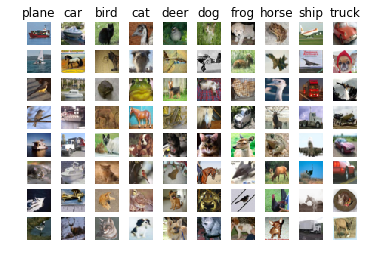

In [14]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?  
\- \-|| no

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [15]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [ ]:
from cs231n.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None
best = -1
################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# Your code
learning_rates = [1e0, 1e-1, 1e-2]
regularization_strengths = [1e-1, 1e-2, 1e-3]
for lr in learning_rates:
    for reg in regularization_strengths:
        net = TwoLayerNet(input_dim, hidden_dim, num_classes)
        stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
                num_iters=5000, batch_size=200,
                learning_rate=lr, learning_rate_decay=0.95,
                reg=reg, verbose=True)

        # Predict on the validation set
        val_acc = (net.predict(X_val_feats) == y_val).mean()
        print('Validation accuracy: ', val_acc)
        if val_acc > best:
            best = val_acc
            best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 5000: loss 2.302666
iteration 100 / 5000: loss 2.170519
iteration 200 / 5000: loss 2.107835
iteration 300 / 5000: loss 2.250646
iteration 400 / 5000: loss 2.161974
iteration 500 / 5000: loss 2.188179
iteration 600 / 5000: loss 2.222574
iteration 700 / 5000: loss 2.171169
iteration 800 / 5000: loss 2.191128
iteration 900 / 5000: loss 2.202028
iteration 1000 / 5000: loss 2.185155
iteration 1100 / 5000: loss 2.189250
iteration 1200 / 5000: loss 2.207266
iteration 1300 / 5000: loss 2.211468
iteration 1400 / 5000: loss 2.174144
iteration 1500 / 5000: loss 2.182219
iteration 1600 / 5000: loss 2.130267
iteration 1700 / 5000: loss 2.173147
iteration 1800 / 5000: loss 2.122475
iteration 1900 / 5000: loss 2.178418
iteration 2000 / 5000: loss 2.179161
iteration 2100 / 5000: loss 2.191746
iteration 2200 / 5000: loss 2.123873
iteration 2300 / 5000: loss 2.149824
iteration 2400 / 5000: loss 2.188852
iteration 2500 / 5000: loss 2.170099
iteration 2600 / 5000: loss 2.172217
iteration 270

iteration 2100 / 5000: loss 1.611167
iteration 2200 / 5000: loss 1.536217
iteration 2300 / 5000: loss 1.656467
iteration 2400 / 5000: loss 1.609781
iteration 2500 / 5000: loss 1.482373
iteration 2600 / 5000: loss 1.611549
iteration 2700 / 5000: loss 1.511944
iteration 2800 / 5000: loss 1.558878
iteration 2900 / 5000: loss 1.633193
iteration 3000 / 5000: loss 1.533138
iteration 3100 / 5000: loss 1.520158
iteration 3200 / 5000: loss 1.493342
iteration 3300 / 5000: loss 1.531837
iteration 3400 / 5000: loss 1.495759
iteration 3500 / 5000: loss 1.564914
iteration 3600 / 5000: loss 1.600932
iteration 3700 / 5000: loss 1.595785
iteration 3800 / 5000: loss 1.598256
iteration 3900 / 5000: loss 1.619342
iteration 4000 / 5000: loss 1.538196
iteration 4100 / 5000: loss 1.576632
iteration 4200 / 5000: loss 1.482391
iteration 4300 / 5000: loss 1.558362
iteration 4400 / 5000: loss 1.495719
iteration 4500 / 5000: loss 1.545038
iteration 4600 / 5000: loss 1.582638
iteration 4700 / 5000: loss 1.514558
i

In [18]:
# Run your best neural net  classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

AttributeError: 'NoneType' object has no attribute 'predict'